# Modelling Genre

## Preprocess the data

Tagging done with spacy=2.0.4. Only provide this dataset.

In [ ]:
import os
import json
import glob
import shutil

In [ ]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# limit to only three tags in Universal Part-of-Speech tagset
allowed = set('ADJ NOUN VERB'.split())

def preprocess(filenames, max_nb=None):
    #try:
    #    shutil.rmtree('books')
    #except FileNotFoundError:
    #    pass
    os.mkdir('books')
    
    books = {}
    for filename in filenames:
        comps = filename.split('/')
        genre, title = comps[-2:]
        
        if title in books:
            books[title].append(genre)
            continue
        else:
            books[title] = [genre]
        
        with open(filename, 'r') as f:
            try:
                text = f.read()
            except UnicodeDecodeError:
                continue
            tokens = nlp(text)
            if tokens:
                with open('books/' + title, 'w') as newf:
                    for t in tokens:
                        if t.pos_ in allowed and t.is_alpha and not t.is_stop:
                            newf.write(t.text.lower() + ' ')
        if max_nb and len(books) > max_nb:
            break
    
    with open('books_meta.json', 'w') as f:
        f.write(json.dumps(books, indent=4))

In [ ]:
import glob
path = '/Users/mike/GitRepos/potter/data/other/books_txt_full/*/*.txt'
filenames = sorted(list(glob.glob(path)))
preprocess(filenames)

## Inspect the data

Define a chunk yielder:

In [2]:
import glob
import random
RND = 12345
random.seed(RND)

class Chunker(object):
    def __init__(self, filenames, metadata, singles_only=False,
                 max_per_book=None, chunk_size=None):
        self.max_per_book = max_per_book
        self.chunk_size = chunk_size
        self.filenames = filenames
        self.meta = meta
        self.singles_only = singles_only
        
        # only collect genres during the first iteration
        self.first = True

    def __iter__(self):
        if self.first:
            self.genres = []
        for filename in self.filenames:
            title = os.path.basename(filename)
            current_genres = self.meta[title]
            if self.singles_only:
                if len(current_genres) > 1:
                    continue

            with open(filename, 'r') as f:
                try:
                    if self.max_per_book:
                        text = f.read(self.max_per_book)
                    else:
                        text = f.read()
                except:
                    continue
            tokens = text.split()
            for i in range(0, len(tokens), self.chunk_size):
                if self.first:
                    self.genres.append(current_genres)
                yield tokens[i:i + self.chunk_size]
        
        # stop collecting labels
        self.first = False

Set hyperparams:

In [117]:
n_features = 5000
n_topics = 300
n_top_words = 60
max_df = 0.5
min_df = 100
max_books = None
chunk_size = 1800
max_per_book = None

Make a split at the book level to avoid overfitting:

In [102]:
path = 'books/*.txt'
filenames = sorted(list(glob.glob(path)))

Collect metadata:

In [103]:
import json
with open('books_meta.json', 'r') as f:
    meta = json.loads(f.read())

In [104]:
random.seed(RND)
random.shuffle(filenames)
print(filenames[:10])
print(len(filenames))

['books/We_Can_Build_You.txt', 'books/PrinceCaspian.txt', 'books/Big_Girls_Do_06.txt', 'books/392303.txt', 'books/421926.txt', 'books/229689.txt', 'books/439376.txt', 'books/u3720.txt', 'books/u3906.txt', 'books/u4145.txt']
6800


Development truncation:

In [105]:
if max_books:
    filenames = filenames[:max_books]
print(len(filenames))

6800


Inspect genre overlap (in the entire corpus):

In [106]:
chunker = Chunker(filenames, metadata=meta, singles_only=False)

In [107]:
from collections import Counter
mults = Counter([len(genres) for title, genres in chunker.meta.items()])
print(mults)

Counter({1: 4257, 2: 2101, 3: 741, 4: 82, 5: 6})


How often do books have multiple genres?

Text(0.5,1,'Distribution of genres over books')

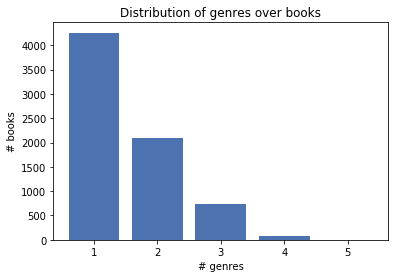

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
x, heights = list(zip(*mults.items()))
plt.bar(x=x, height=heights)
plt.xlabel('# genres')
plt.ylabel('# books')
plt.title('Distribution of genres over books')

How do genre labels cooccur?

['Adventure', 'Fantasy', 'Historical', 'Horror', 'Humor', 'Literature', 'Mystery', 'New_Adult', 'Other', 'Romance', 'Science_fiction', 'Teen', 'Themes', 'Thriller', 'Vampires', 'Young_Adult']


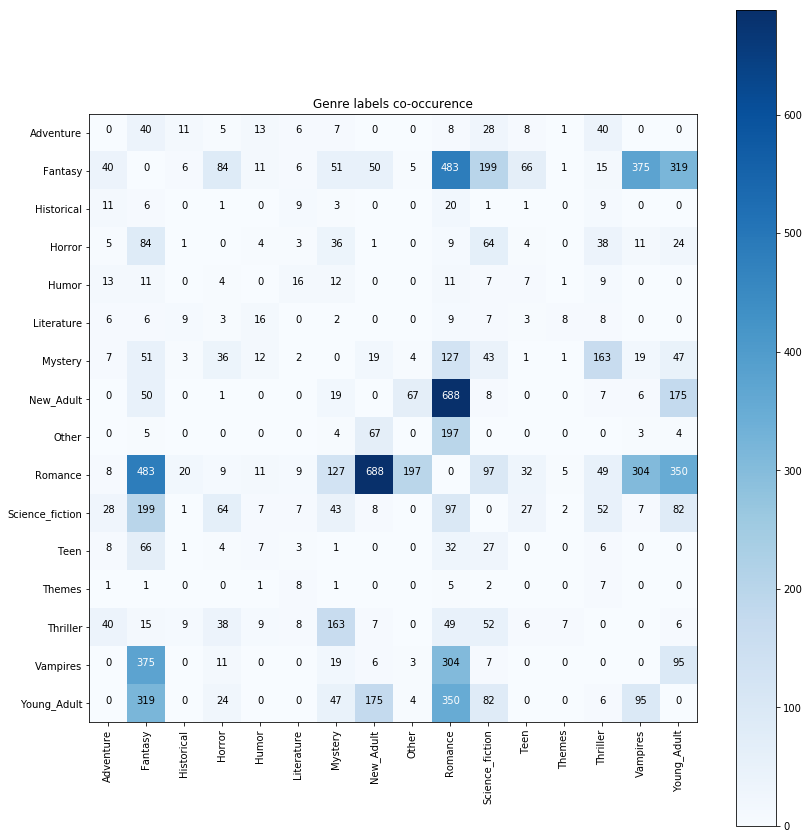

In [109]:
from itertools import combinations
import numpy as np
from itertools import product

G = sorted(set([label for labels in chunker.meta.values() for label in labels]))
C = np.zeros((len(G), len(G)), dtype=np.int64)
print(G)

for _, genres in chunker.meta.items():
    for a, b in combinations(genres, 2):
        C[G.index(a), G.index(b)] += 1
        C[G.index(b), G.index(a)] += 1

plt.figure(figsize=(12, 12))
ax = plt.imshow(C, interpolation='nearest', cmap=plt.cm.Blues)
plt.gca().grid(False)
plt.title('Genre labels co-occurence')
plt.colorbar()
tick_marks = np.arange(len(G))
plt.xticks(tick_marks, G, rotation=90)
plt.yticks(tick_marks, G)

thresh = C.max() / 2.
for i, j in product(range(C.shape[0]), range(C.shape[1])):
    plt.text(j, i, format(C[i, j], 'd'),
             horizontalalignment="center",
             color="white" if C[i, j] > thresh else "black")

plt.tight_layout()

How common is each genre?

Text(0.5,1,'Distribution of genres over books')

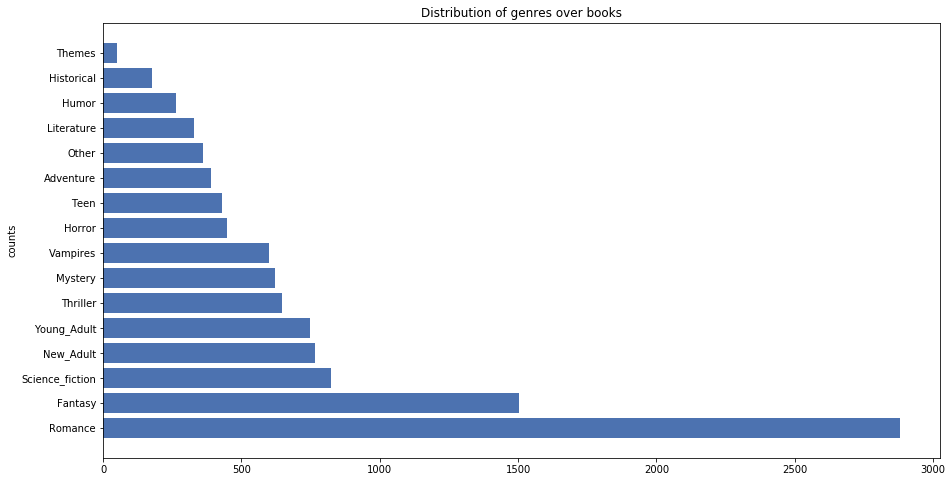

In [110]:
from operator import itemgetter
plt.figure(figsize=(15, 8))
G = Counter([label for labels in chunker.meta.values() for label in labels])
labels, heights = list(zip(*sorted(list(G.items()), key=itemgetter(1), reverse=True)))
plt.barh(y=range(len(heights)), width=heights)
plt.yticks(range(len(labels)), labels)
plt.ylabel('counts')
plt.title('Distribution of genres over books')

## Semantic modelling

### Topic modelling

In [111]:
chunks = Chunker(filenames, meta,
                 chunk_size=chunk_size,
                 max_per_book=max_per_book)

In [112]:
from sklearn.feature_extraction.text import CountVectorizer

def identity(x):
    return x

vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)
X = vectorizer.fit_transform(chunks)
print(X.shape)
print(vectorizer.get_feature_names()[:100])
print('nb of features:', len(vectorizer.get_feature_names()))

(98326, 5000)
['a', 'abandon', 'abandoned', 'abdomen', 'abilities', 'ability', 'abrupt', 'absence', 'absolute', 'absorbed', 'abuse', 'accent', 'accept', 'acceptance', 'accepted', 'accepting', 'access', 'accident', 'accompanied', 'accompany', 'accomplish', 'accomplished', 'according', 'account', 'accounts', 'accurate', 'accused', 'accustomed', 'ache', 'ached', 'achieve', 'aching', 'acknowledge', 'acknowledged', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'activities', 'activity', 'acts', 'actual', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'addressed', 'adds', 'adjust', 'adjusted', 'admire', 'admired', 'admiring', 'admit', 'admitted', 'adopted', 'adorable', 'adrenaline', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'advised', 'affair', 'affairs', 'affect', 'affected', 'affection', 'afford', 'afraid', 'afternoon', 'age', 'aged', 'agency', 'agent', 'agents', 'ages', 'aggressive', 'agitated', 'agony', 'agree', 'agreed', 'agr

In [123]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_ = transformer.fit_transform(X)

In [118]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=n_topics, random_state=RND, verbose=1, max_iter=50).fit(X_)

violation: 1.0
violation: 0.8412227133864387
violation: 3.064716940018332
violation: 2.437443265698119
violation: 2.0772825549811866
violation: 1.5638288845516715
violation: 1.1444754128498347
violation: 0.9274522218216542
violation: 0.7612455763643337
violation: 0.5991575220229579
violation: 0.4654004854332048
violation: 0.37614943477612217
violation: 0.30720055135568364
violation: 0.25477119104342943
violation: 0.2126060447190822
violation: 0.17779424909090982
violation: 0.151209542620454
violation: 0.13112314976087333
violation: 0.11642674149678146
violation: 0.10237060702347577
violation: 0.09185972827767028
violation: 0.08261038832450694
violation: 0.07480379124758015
violation: 0.068102329991648
violation: 0.06214852016454545
violation: 0.057193296386288624
violation: 0.053236137536233914
violation: 0.04996018501505986
violation: 0.047494925278125134
violation: 0.04568924377279725
violation: 0.04466800233107441
violation: 0.04457783642274944
violation: 0.04402389742758692
violati

### Reading tea leaves

In [119]:
import os
import shutil
from wordcloud import WordCloud
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

def top_words(model, feature_names, n_top_words):
    try:
        shutil.rmtree('clouds')
    except:
        pass
    os.mkdir('clouds')

    for topic_idx, topic in enumerate(model.components_):
        print('.', end='')
        topic = np.nan_to_num(topic)
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]

        weights = [topic[i] for i in topic.argsort()[:-n_top_words-1:-1]]

        freqs = {wo: we for wo, we in zip(words, weights)}
        wordcloud = WordCloud(normalize_plurals=False,
                                  background_color='white',
                                  colormap='inferno_r',
                                  width=800,
                                  height=400)
        wordcloud = wordcloud.generate_from_frequencies(freqs)
        plt.imsave('clouds/'+str(topic_idx) + '.tiff',
                          wordcloud, dpi=1000)

feature_names = vectorizer.get_feature_names()
info = top_words(nmf, feature_names, 50)

............................................................................................................................................................................................................................................................................................................

In [116]:
#!pip install pyldavis
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.sklearn
pyLDAvis.sklearn.prepare(nmf, X, vectorizer)
# student assignment: provide short interpretative labels for each topic

violation: 1.0
violation: 0.4470296391107128
violation: 0.13432562449052343
violation: 0.051984858927595974
violation: 0.02256565210921112
violation: 0.010449603592128164
violation: 0.004586713881958214
violation: 0.002054442324717274
violation: 0.0009924751528092356
violation: 0.00048072139220801404
violation: 0.00023112905435781168
violation: 0.00010976979026128822
violation: 5.437072266201759e-05
Converged at iteration 13


//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/sklearn.py:26: RuntimeWarning: invalid value encountered in true_divide
  return dists / dists.sum(axis=1)[:, None]
//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/_prepare.p

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
4      4.445430        1       1  0.112365  0.100842
0      4.432495        1       2 -0.039639 -0.138175
3      3.974051        1       3  0.028769 -0.085427
18     3.775978        1       4  0.070602 -0.140132
37     3.751537        1       5  0.185837 -0.103674
39     3.336610        1       6 -0.201950  0.032783
42     3.305069        1       7  0.011727 -0.045501
31     3.222861        1       8 -0.147699  0.085776
32     3.002405        1       9 -0.083632 -0.194056
8      2.915824        1      10 -0.188784  0.058062
13     2.858826        1      11 -0.038085  0.252578
40     2.840962        1      12 -0.120355  0.108577
22     2.801685        1      13 -0.035824 -0.055563
35     2.486369        1      14  0.145217  0.128747
11     2.458268        1      15  0.021549 -0.031832
16     2.455286        1      16 -0.197983  0.030905
2      2.435369        1      17 -0.057169 -0.005262
46     2.392858        1      18 -0.135174  0.032696
1      2.139126        1      19 -0.063168 -0.054841
6      2.130972        1      20 -0.146051 -0.111025
10     2.117733        1      21 -0.148547  0.019087
43     2.108398        1      22 -0.193950 -0.070407
30     2.100505        1      23 -0.119819 -0.000202
34     2.089737        1      24 -0.032032  0.048931
24     1.895140        1      25  0.190550  0.093027
49     1.832109        1      26  0.196074  0.101525
45     1.825394        1      27  0.019388  0.221962
44     1.601352        1      28 -0.239191 -0.043870
36     1.549827        1      29 -0.043485  0.004022
38     1.511146        1      30  0.017669  0.269773
47     1.505643        1      31  0.016795  0.093601
19     1.482175        1      32 -0.239253 -0.035669
12     1.481199        1      33  0.167183  0.029914
28     1.410760        1      34  0.077931 -0.126575
27     1.353274        1      35  0.262081 -0.072767
23     1.342014        1      36  0.023684 -0.058190
9      1.303236        1      37 -0.162984 -0.089100
26     1.290567        1      38  0.099499  0.110908
5      1.276504        1      39  0.131582 -0.159691
41     1.253543        1      40  0.102427  0.123582
7      1.247740        1      41  0.147274  0.127444
21     0.919789        1      42  0.062965  0.197991
20     0.805127        1      43  0.171455 -0.187751
14     0.785912        1      44  0.166078 -0.146428
15     0.702193        1      45  0.101930 -0.168018
29     0.584976        1      46  0.168628 -0.111288
48     0.480364        1      47  0.105456  0.089445
33     0.475710        1      48 -0.049331 -0.073380
17     0.286924        1      49 -0.085627 -0.011084
25     0.219023        1      50 -0.034981 -0.042271, topic_info=     Category           Freq       Term          Total  loglift  logprob
term                                                                    
531   Default  419650.000000    brother  419650.000000  30.0000  30.0000
490   Default  406814.000000        boy  406814.000000  29.0000  29.0000
3935  Default  330189.000000     sister  330189.000000  28.0000  28.0000
3695  Default  282514.000000       says  282514.000000  27.0000  27.0000
2765  Default  233798.000000        mom  233798.000000  26.0000  26.0000
622   Default  247961.000000        car  247961.000000  25.0000  25.0000
1106  Default  181504.000000        dad  181504.000000  24.0000  24.0000
3512  Default  184040.000000    replied  184040.000000  23.0000  23.0000
3101  Default  173920.000000      phone  173920.000000  22.0000  22.0000
4481  Default  114815.000000      tessa  114815.000000  21.0000  21.0000
280   Default  135297.000000       baby  135297.000000  20.0000  20.0000
4026  Default  119060.000000       snow  119060.000000  19.0000  19.0000
4747  Default  102733.000000    vampire  102733.000000  18.0000  18.0000
309   Default  123846.000000        bar  123846.000000  17.0000  17.0000
3847  Default   99490.000000     

## Apply to HP

In [ ]:
from lxml import etree
from collections import OrderedDict

def load_potter(fn):
    series = etree.parse(fn)
    HP = OrderedDict()
    for book in series.iterfind('.//book'):
        book_title = book.attrib['title']
        #print(book_title)
        HP[book_title] = OrderedDict()
        
        for chapter in book.iterfind('.//chapter'):
            chapter_title = chapter.attrib['title']
            #print('   ', chapter_title)
            HP[book_title][chapter_title] = []
            
            for paragraph in chapter.iterfind('.//p'):
                text = ''.join([x for x in paragraph.itertext()])
                HP[book_title][chapter_title].append(text)
    return HP

US_HP = load_potter('../preprocessing/simple_potter_us.xml')

In [ ]:
try:
    shutil.rmtree('hp')
except FileNotFoundError:
    pass
os.mkdir('hp')

In [134]:
cnt = 0
lens = []
for book_title in US_HP:
    for idx, chap_title in enumerate(US_HP[book_title]):
        cnt += 1
        id_ = (4 - len(str(cnt))) * '0' + str(cnt)
        filename = 'hp/' + id_ + '+' + book_title.replace(' ', '_') + '+' + chap_title.replace(' ', '_') + '.txt'
        with open(filename, 'w') as newf:
            chap_text = ' '.join(US_HP[book_title][chap_title])
            token_cnt = 0
            for t in nlp(chap_text):
                if t.pos_ in allowed and t.is_alpha and not t.is_stop:
                    newf.write(t.text.lower() + ' ')
                    token_cnt += 1
        lens.append(token_cnt)    
print('mean len:', np.mean(lens))

NameError: name 'US_HP' is not defined

In [135]:
import pandas as pd
nmf.verbose = 0
df = pd.DataFrame(columns=['book', 'chapter'])
filenames = sorted(glob.glob('hp/*.txt'), key=lambda v: int(v.split('+')[0].split('/')[1]))
texts = []
for filename in filenames:
    with open(filename, 'r') as f:
        tokens = f.read().split()
    cnt, title, chap = os.path.basename(filename).replace('.txt', '').split('+')
    texts.append(tokens)
    df.loc[len(df)] = [title, chap]

scores = nmf.transform(transformer.transform(vectorizer.transform(texts)))
print(scores.shape)

(397, 300)


In [136]:
df_scores = pd.DataFrame(scores, columns=[f't{i+1}' for i in range(n_topics)])
df = df.join(df_scores)
df

,book,chapter,t1,t2,t3,t4,t5,t6,t7,t8,...,t291,t292,t293,t294,t295,t296,t297,t298,t299,t300
0,Harry_Potter_and_the_Sorcerer's_Stone,THE_BOY_WHO_LIVED,0.009784,0.000000,0.000000,0.000000,0.002973,0.000000,0.000000,1.739265e-05,...,0.004195,0.004315,0.000000,0.001102,0.000000,0.000244,0.000000,0.000000,0.000000,0.000209
1,Harry_Potter_and_the_Sorcerer's_Stone,THE_VANISHING_GLASS,0.000000,0.000000,0.000000,0.000000,0.000502,0.000000,0.023688,0.000000e+00,...,0.000066,0.003774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Harry_Potter_and_the_Sorcerer's_Stone,THE_VANISHING_GLASS,0.000000,0.000000,0.000000,0.000000,0.000502,0.000000,0.023688,0.000000e+00,...,0.000066,0.003774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Harry_Potter_and_the_Sorcerer's_Stone,THE_LETTERS_FROM_NO_ONE,0.005826,0.000000,0.000000,0.000000,0.000039,0.000025,0.006108,0.000000e+00,...,0.007003,0.000935,0.000000,0.000000,0.000000,0.000000,0.012322,0.000000,0.000000,0.000000
4,Harry_Potter_and_the_Sorcerer's_Stone,THE_LETTERS_FROM_NO_ONE,0.005826,0.000000,0.000000,0.000000,0.000039,0.000025,0.006108,0.000000e+00,...,0.007003,0.000935,0.000000,0.000000,0.000000,0.000000,0.012322,0.000000,0.000000,0.000000
5,Harry_Potter_and_the_Sorcerer's_Stone,THE_KEEPER_OF_THE_KEYS,0.000000,0.000318,0.000076,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.007271,0.012181,0.000000,0.000000,0.000000,0.000201,0.000646,0.000000,0.000000,0.000000
6,Harry_Potter_and_the_Sorcerer's_Stone,THE_KEEPER_OF_THE_KEYS,0.000000,0.000318,0.000076,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.007271,0.012181,0.000000,0.000000,0.000000,0.000201,0.000646,0.000000,0.000000,0.000000
7,Harry_Potter_and_the_Sorcerer's_Stone,DIAGON_ALLEY,0.000000,0.000191,0.000922,0.000000,0.000751,0.000029,0.000000,0.000000e+00,...,0.027035,0.016534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000201,0.000000,0.000000
8,Harry_Potter_and_the_Sorcerer's_Stone,DIAGON_ALLEY,0.000000,0.000191,0.000922,0.000000,0.000751,0.000029,0.000000,0.000000e+00,...,0.027035,0.016534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000201,0.000000,0.000000
9,Harry_Potter_and_the_Sorcerer's_Stone,THE_JOURNEY_FROM_PLATFORM_NINE_AND_THREE-QUARTERS,0.004774,0.000188,0.000869,0.000000,0.000024,0.000043,0.003651,1.181600e-04,...,0.012134,0.005269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [139]:
from scipy.stats import kendalltau
ranks = range(1, len(df.index)+1)
tau_scores = []
for col in [f't{i+1}' for i in range(n_topics)]:
    tau, p = kendalltau(ranks, df[col].tolist())
    tau_scores.append((col, tau))
tau_scores

[('t1', 0.012184952657709868),
 ('t2', -0.0033996647206323894),
 ('t3', 0.064599543969865156),
 ('t4', 0.11658419510245864),
 ('t5', 0.013626694646455035),
 ('t6', -0.044765295343554036),
 ('t7', -0.13482449663698035),
 ('t8', -0.064862478547669009),
 ('t9', -0.0058601515343015336),
 ('t10', 0.0049750677062186249),
 ('t11', -0.087527639630590306),
 ('t12', 0.096566568524104682),
 ('t13', 0.071459316323746067),
 ('t14', -0.13829969440300474),
 ('t15', -0.14235478354007064),
 ('t16', 0.043836344461410708),
 ('t17', 0.14394901515450303),
 ('t18', -0.086909920668937907),
 ('t19', 0.10165502531038909),
 ('t20', -0.11605760817635033),
 ('t21', 0.11195535989351628),
 ('t22', 0.024777233784770682),
 ('t23', -0.090596753230667973),
 ('t24', 0.035367665481396249),
 ('t25', 0.0072501904904783369),
 ('t26', 0.21949838075373265),
 ('t27', -0.10080900198749117),
 ('t28', 0.28274587769246079),
 ('t29', 0.089435057885830171),
 ('t30', -0.01176593103401719),
 ('t31', -0.032410015864087517),
 ('t32', 0.

In [141]:
tau_scores.sort(key=itemgetter(1))
nb = 5
top, bottom = tau_scores[:nb], tau_scores[-nb:]

Text(0.5,1,'The 5 nouns with the steadiest frequency decrease in Speculum')

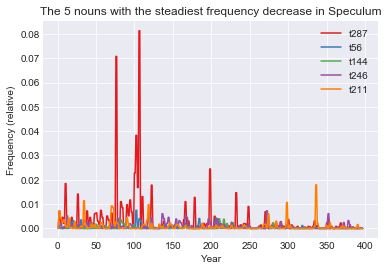

In [148]:
fig = plt.figure()
sb.set_style("darkgrid")
for (feat, tau), col in zip(top, sb.color_palette("Set1")[:nb]):
    plt.plot(ranks, df[feat].tolist(), label=feat, c=col)
plt.legend(loc="best")
plt.xlabel('Year', fontsize=10)
plt.ylabel('Frequency (relative)', fontsize=10)
plt.title('The 5 nouns with the steadiest frequency decrease in Speculum')

Text(0.5,1,'The 5 nouns with the steadiest frequency increase in Speculum')

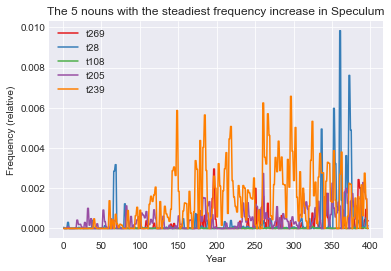

In [149]:
fig = plt.figure()
sb.set_style("darkgrid")
for (feat, tau), col in zip(bottom, sb.color_palette("Set1")[:nb]):
    plt.plot(ranks, df[feat].tolist(), label=feat, c=col)
plt.legend(loc="best")
plt.xlabel('Year', fontsize=10)
plt.ylabel('Frequency (relative)', fontsize=10)
plt.title('The 5 nouns with the steadiest frequency increase in Speculum')

In [153]:
for feat, tau in bottom:
    print(feat)
    idx = int(feat.replace('t', '')) - 1
    topic = nmf.components_[idx, :]
    words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(' - '.join(words))

t269
warrior - warriors - tribe - battle - weapons - order - slave - slaves - leader - spoke - spear - drew - compound - centuries - land - weapon - shield - mist - axe - strength - enemy - powerful - death - strong - fold - future - vision - heavens - leather - fangs - swords - cried - fought - blades - sent - wore - shouted - fierce - heavy - honor - speak - lands - combat - strode - chamber - golden - gathered - lad - direction - mighty - arena - challenge - defeat - savage - flame - released - healing - folded - wish - carried
t28
sword - blade - swords - hilt - battle - fight - weapon - blow - shield - attack - armor - swung - fighting - drew - raised - thrust - opponent - strike - cloak - swing - blades - steel - charged - fought - struck - weapons - blows - axe - lunged - swinging - inn - wound - tip - sliced - blocked - attacked - strength - glory - fallen - grip - belt - leapt - bloody - spear - staggered - landed - practice - companions - roared - stabbed - skill - glowing - 

## Prepare single-label classification task

In [ ]:
from sklearn.model_selection import train_test_split
trainfiles, testfiles = train_test_split(filenames,
                                         train_size=.9,
                                         test_size=.1,
                                         shuffle=True,
                                         random_state=RND)
print(len(trainfiles))
print(len(testfiles))

In [ ]:
train_chunks = Chunker(trainfiles,
                       singles_only=True,
                       chunk_size=chunk_size,
                       max_per_book=max_per_book,
                       metadata=meta)
vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)

train_X = vectorizer.fit_transform(train_chunks)
train_genres = train_chunks.genres

print(vectorizer.get_feature_names()[:100])
print('nb of features:', len(vectorizer.get_feature_names()))

In [ ]:
test_chunks = Chunker(testfiles, metadata=meta,
                      singles_only=True,
                      chunk_size=chunk_size,
                      max_per_book=max_per_book)
test_X = vectorizer.transform(test_chunks)
test_genres = test_chunks.genres
print(test_X.shape)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
transformer.fit(train_X)

train_X_norm = transformer.transform(train_X).toarray()
test_X_norm = transformer.transform(test_X).toarray()

print(train_X_norm.shape)
print(test_X_norm.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit([t[0] for t in train_genres])
train_ints = encoder.transform([t[0] for t in train_genres])
test_ints = encoder.transform([t[0] for t in test_genres])
print(train_ints.shape)
print(test_ints.shape)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()
train_y = binarizer.fit_transform(train_ints)
test_y = binarizer.transform(test_ints)
print(train_y.shape)
print(test_y.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dropout(0.5, input_shape=(train_X_norm.shape[1],)))
model.add(Dense(units=len(encoder.classes_)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.fit(train_X_norm, train_y,
          validation_split=0.1,
          epochs=10, batch_size=128)

First test on train:

In [ ]:
from pandas import DataFrame
from IPython.display import HTML
HTML(DataFrame(train_y, columns=encoder.classes_).head(10).to_html())

In [ ]:
train_pred = model.predict(train_X_norm)
HTML(DataFrame(train_pred, columns=encoder.classes_).head(10).to_html())

In [ ]:
train_pred_int = model.predict_classes(train_X_norm)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
acc = accuracy_score(train_pred_int, train_ints)
f1 = f1_score(train_pred_int, train_ints, average='weighted')
print('accuracy: ', acc)
print('f1 score: ', f1)

Now move to test:

In [ ]:
test_pred_ints = model.predict_classes(test_X_norm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_pred_ints, test_ints, target_names=encoder.classes_))

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_pred_ints, test_ints)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(20, 20))
plot_confusion_matrix(cnf_matrix, classes=encoder.classes_, normalize=False,
                      title='Normalized confusion matrix')

In [ ]:
W = model.get_weights()[0].T
print(W.shape)
vocab = np.array(vectorizer.get_feature_names())
print(vocab.shape)
for genre_idx, genre in enumerate(encoder.classes_):
    top_idxs = np.argsort(W[genre_idx, :])[::-1][:10]
    top_words = vocab[top_idxs]
    print(genre, ':', ' - '.join(top_words))

## Multilabel setup

In [ ]:
train_chunks = Chunker(trainfiles,
                       singles_only=True,
                       chunk_size=chunk_size,
                       max_per_book=max_per_book,
                       metadata=meta)
vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)

train_X = vectorizer.fit_transform(train_chunks)
train_genres = train_chunks.genres



print(vectorizer.get_feature_names()[:100])
print('nb of features:', len(vectorizer.get_feature_names()))

In [ ]:
test_chunks = Chunker(testfiles, meta,
                      singles_only=False,
                      chunk_size=chunk_size,
                      max_per_book=max_per_book)
test_X = vectorizer.transform(test_chunks)
print(test_X.shape)

In [ ]:
transformer = TfidfTransformer()
transformer.fit(train_X)

train_X_norm = transformer.transform(train_X)
test_X_norm = transformer.transform(test_X)

print(train_X_norm.shape)
print(test_X_norm.shape)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
encoder = MultiLabelBinarizer()
train_Y = encoder.fit_transform(train_chunks.genres)
test_Y = encoder.transform(test_chunks.genres)
print(train_Y.shape)
print(test_Y.shape)

In [ ]:
HTML(DataFrame(test_Y, columns=encoder.classes_).head(20).to_html())

In [ ]:
model = Sequential()
model.add(Dense(units=len(encoder.classes_),
                activation='sigmoid',
                input_dim=train_X_norm.shape[1]))
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['binary_accuracy'])

model.fit(train_X_norm, train_Y,
          validation_split=0.1,
          epochs=1, batch_size=128)

In [ ]:
test_pred_Y = model.predict(test_X_norm)
HTML(DataFrame(test_pred_Y, columns=encoder.classes_).head(20).to_html())

In [ ]:
test_pred_int = np.zeros(test_pred_Y.shape, dtype='int32')
test_pred_int[test_pred_Y > 0.5] = 1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
acc = accuracy_score(test_pred_int, test_Y)
f1 = f1_score(test_pred_int, test_Y, average='weighted')
hamming = hamming_loss(test_pred_int, test_Y)
print('accuracy: ', acc)
print('f1 score: ', f1)
print('hamming loss: ', hamming)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_pred_int, test_Y, target_names=encoder.classes_))

## Applying to HP